In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [ ]:
print(f"First 5 X feat:\n{X[:5]}")
print(f"First 5 y feat:\n{y[:5]}")

First 5 X feat:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 y feat:
[1 1 1 1 0]


In [ ]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y
                        })
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [ ]:
circles["label"].value_counts()

1    500
0    500
Name: label, dtype: int64

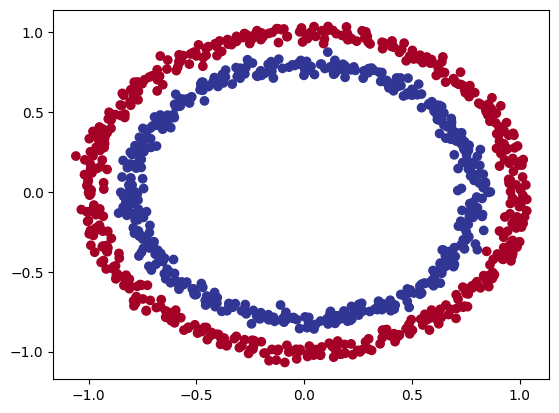

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x=circles.X1,
            y=circles.X2,
            c=y,
            cmap=plt.cm.RdYlBu);

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size= 0.2,
                                                    random_state=15)

len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

# 2.Building a Model

In [ ]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Construc a model class

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # Create 2 nn.Linear layers
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # 2 => X -> 5
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # 5 -> 1 => y

    def forward(self, x):
      return self.layer_2(self.layer_1(x)) # first goes to layer_1 whose output goes to layer_2 as an input which results in y as output

model_0 = CircleModelV0()
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# Using nn.Sequential

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
untrained_preds = model_0(X_test.to(device))

## Setup loss func and optimizer

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

# Training Model

In [ ]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.4159],
        [ 0.5742],
        [-0.0710],
        [ 0.1981],
        [-0.1846]], device='cuda:0', grad_fn=<SliceBackward0>)

In [ ]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6025],
        [0.6397],
        [0.4823],
        [0.5494],
        [0.4540]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
y[0:5]

tensor([1., 1., 1., 1., 0.])

In [ ]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 0., 1., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [ ]:
torch.manual_seed(15)

epochs = 100


X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()

  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70762, Accuracy: 50.25% | Test loss: 0.69429, Test acc: 56.00%
Epoch: 10 | Loss: 0.70710, Accuracy: 50.00% | Test loss: 0.69408, Test acc: 56.00%
Epoch: 20 | Loss: 0.70661, Accuracy: 49.88% | Test loss: 0.69389, Test acc: 55.50%
Epoch: 30 | Loss: 0.70613, Accuracy: 50.12% | Test loss: 0.69371, Test acc: 55.50%
Epoch: 40 | Loss: 0.70568, Accuracy: 50.38% | Test loss: 0.69355, Test acc: 55.00%
Epoch: 50 | Loss: 0.70525, Accuracy: 50.25% | Test loss: 0.69340, Test acc: 55.00%
Epoch: 60 | Loss: 0.70484, Accuracy: 50.12% | Test loss: 0.69327, Test acc: 55.00%
Epoch: 70 | Loss: 0.70444, Accuracy: 50.25% | Test loss: 0.69315, Test acc: 54.50%
Epoch: 80 | Loss: 0.70406, Accuracy: 50.25% | Test loss: 0.69305, Test acc: 54.50%
Epoch: 90 | Loss: 0.70370, Accuracy: 50.38% | Test loss: 0.69295, Test acc: 54.50%


# 4. Make predictions and evaluate the model

In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

already exists


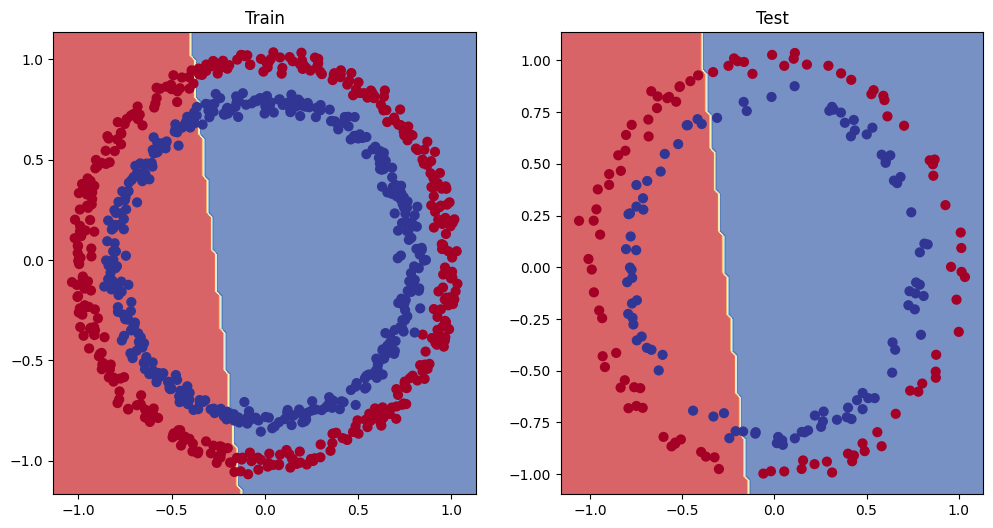

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# 5. Improving a model

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    # Create 2 nn.Linear layers
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1()
model_1 = model_1.to(device)

In [ ]:
model_1.parameters

<bound method Module.parameters of CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)>

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(15)

epochs = 1000


X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()

  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69512, Accuracy: 55.38% | Test loss: 0.69860, Test acc: 56.00%
Epoch: 10 | Loss: 0.69423, Accuracy: 52.88% | Test loss: 0.69725, Test acc: 48.00%
Epoch: 20 | Loss: 0.69394, Accuracy: 51.62% | Test loss: 0.69690, Test acc: 49.00%
Epoch: 30 | Loss: 0.69379, Accuracy: 51.25% | Test loss: 0.69685, Test acc: 49.00%
Epoch: 40 | Loss: 0.69368, Accuracy: 51.00% | Test loss: 0.69692, Test acc: 48.50%
Epoch: 50 | Loss: 0.69360, Accuracy: 50.88% | Test loss: 0.69702, Test acc: 48.50%
Epoch: 60 | Loss: 0.69352, Accuracy: 50.75% | Test loss: 0.69712, Test acc: 48.50%
Epoch: 70 | Loss: 0.69345, Accuracy: 51.25% | Test loss: 0.69722, Test acc: 49.00%
Epoch: 80 | Loss: 0.69340, Accuracy: 51.25% | Test loss: 0.69730, Test acc: 49.00%
Epoch: 90 | Loss: 0.69334, Accuracy: 51.62% | Test loss: 0.69738, Test acc: 48.50%
Epoch: 100 | Loss: 0.69330, Accuracy: 51.38% | Test loss: 0.69745, Test acc: 48.50%
Epoch: 110 | Loss: 0.69326, Accuracy: 51.50% | Test loss: 0.69750, Test acc: 47.50%
Epo

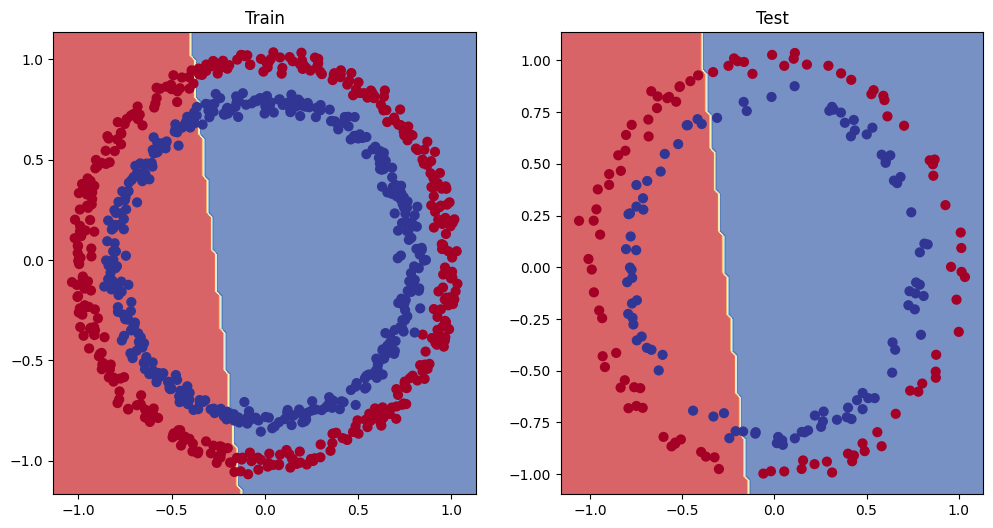

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# 6. Adding non-linearity

In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

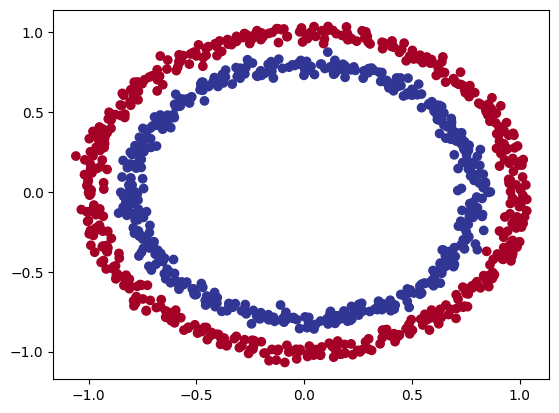

In [ ]:
plt.scatter(x=circles.X1,
            y=circles.X2,
            c=y,
            cmap=plt.cm.RdYlBu);

In [ ]:
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [ ]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2()
model_3.to(device)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.01)

In [ ]:
torch.manual_seed(15)

epochs = 1000


X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()

  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_3.eval()

  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.58209, Accuracy: 93.00% | Test loss: 0.58848, Test acc: 94.00%
Epoch: 10 | Loss: 0.58209, Accuracy: 93.00% | Test loss: 0.58848, Test acc: 94.00%
Epoch: 20 | Loss: 0.58209, Accuracy: 93.00% | Test loss: 0.58848, Test acc: 94.00%
Epoch: 30 | Loss: 0.58209, Accuracy: 93.00% | Test loss: 0.58848, Test acc: 94.00%
Epoch: 40 | Loss: 0.58209, Accuracy: 93.00% | Test loss: 0.58848, Test acc: 94.00%
Epoch: 50 | Loss: 0.58209, Accuracy: 93.00% | Test loss: 0.58848, Test acc: 94.00%
Epoch: 60 | Loss: 0.58209, Accuracy: 93.00% | Test loss: 0.58848, Test acc: 94.00%
Epoch: 70 | Loss: 0.58209, Accuracy: 93.00% | Test loss: 0.58848, Test acc: 94.00%
Epoch: 80 | Loss: 0.58209, Accuracy: 93.00% | Test loss: 0.58848, Test acc: 94.00%
Epoch: 90 | Loss: 0.58209, Accuracy: 93.00% | Test loss: 0.58848, Test acc: 94.00%
Epoch: 100 | Loss: 0.58209, Accuracy: 93.00% | Test loss: 0.58848, Test acc: 94.00%
Epoch: 110 | Loss: 0.58209, Accuracy: 93.00% | Test loss: 0.58848, Test acc: 94.00%
Epo

In [ ]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 0., 1., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

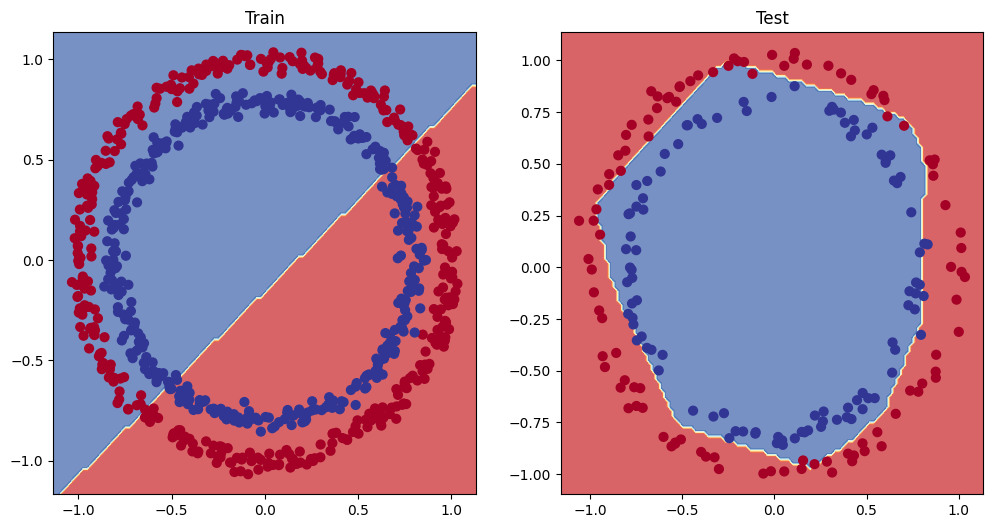

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity